# Validación de Modelos|

## ¿Cómo saber si un modelo es bueno?

![](images/01.png)

## Castigar al modelo

![](images/03.png)

![](images/04.png)

$\lambda$ factor por el que se multiplica el castigo del modelo.

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn import model_selection, preprocessing
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

## Cargar el set de datos
En este laboratorio vamos a validar qué tan bien se están comportando los modelos que realizamos la [clase pasada](./Lab02py_PrediccionClasificacion.ipynb).  Por eso fue tan importante guardar los modelos ya entrenados, para no tener que entrenarlos nuevamente.  
Vamos a continuar usando el set de datos que limpiamos y transformamos en el [primer laboratorio](./Lab01py_Preprocesamiento.ipynb) en donde se registran los atributos de varias botellas de vino junto con su calidad, ya que de este generamos los subsets de entrenamiento y prueba y es precisamente con el de **prueba** que vamos a probar y validar el modelo:

In [2]:
wine_df = pd.read_csv('data/winequality-white_clean.csv')
len(wine_df)

4461

In [3]:
wine_df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,score
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.15
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.67
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.48
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.74
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.45


In [4]:
y = wine_df['score']
x = wine_df.drop(['score', 'density'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## 3a. Predicción  
Si todo ha ido bien, en nuestro [laboratorio anterior](./Lab02py_PrediccionClasificacion.ipynb), hemos guardado el modelo de regresión polinomial, que podemos validar en esta clase.  
Este modelo ya se encuentra entrenado y ahora, solo debemos cargarlo:

In [5]:
with open("models/model_poly.pkl","rb") as f:
    model = pickle.load(f)

### Curvas de Validación
Como ya vimos, una de las formas de ver gráficamente en qué momento un modelo entra en sobreajuste debido a su complejidad es la *curva de Entrenamiento*.
> Vamos a crear una función para poderla usar con varios modelos, sin necesidad de repetir código:

In [6]:
def curva_entrenamiento(modelo, x, y) :
    train_size, train_score, test_score = learning_curve(modelo, x, y, 
                                                         train_sizes=np.linspace(.1, 1.0, 10))
    plt.plot(train_size,np.mean(train_score,axis=1), label="Score Entrenamiento")
    plt.plot(train_size,np.mean(test_score,axis=1),label="Score Pruebas")
    plt.xlabel("Dataset Size")
    plt.ylabel("Score")
    plt.legend()

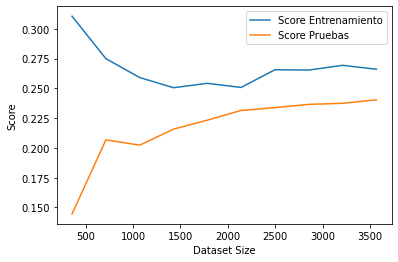

In [7]:
curva_entrenamiento(model, x, y)

### Regularización
Aunque el modelo se ve bien, a medida que el dataset crece, podríamos validar hasta qué punto el modelo se empieza a sobreajustar.  Esto es, reducir la complejidad del modelo (Cantidad o peso de las variables) obteniendo el mismo o mejor resultado.  Para esto existen dos metodos conocidos:  
**Lasso:**

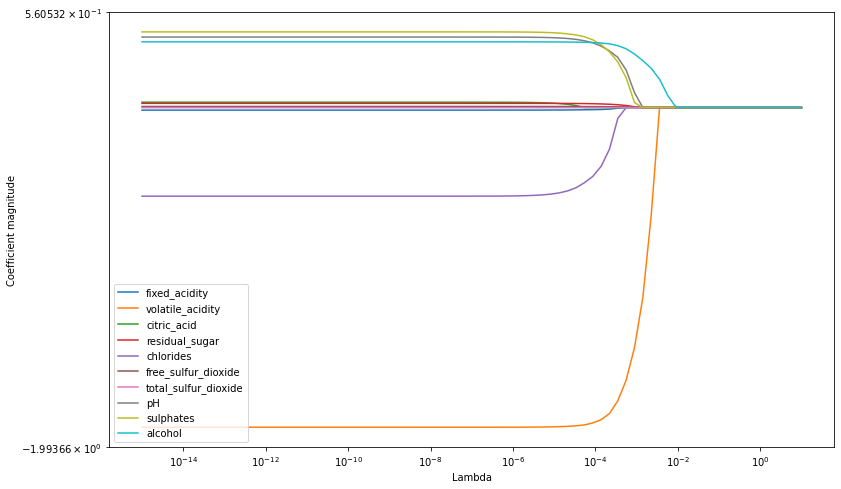

In [8]:
a_exp = np.linspace(-15, 1, num=80)
alpha_range = [10**a for a in a_exp]
coefs = []

for i, alpha in enumerate(alpha_range):
    modelo = linear_model.Lasso(alpha=alpha, normalize=True)
    modelo.fit(x_train, y_train)

    #train_error[i] = mean_squared_error(y_train, modelo.predict(x_train))
    #test_error[i] = mean_squared_error(y_test, modelo.predict(x_test))
    coefs.append(modelo.coef_)

plt.subplots(figsize=(13, 8))
#plt.plot(alpha_range, np.squeeze(coefs, axis=1))
plt.plot(alpha_range, np.squeeze(coefs))
plt.yscale("symlog")
plt.xscale("log")
#plt.xlim(reversed(plt.xlim())) # reverses x axis
plt.ylabel("Coefficient magnitude")
plt.xlabel("Lambda")
plt.legend(x_train.columns, loc='lower left')

En la gráfica anterior se puede visualizar que si penalizamos mucho el peso de las variables (*alpha*), el modelo elimina todas las variables predictivas y esto no nos da ningún resultado.  Validemos ahora cuál es el mejor valor de alpha:

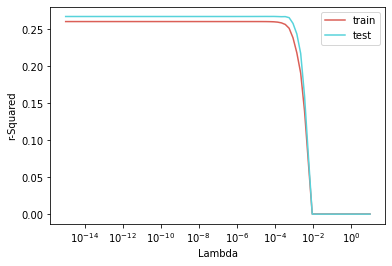

In [9]:
colors = sns.hls_palette(2)

train_error = np.empty(len(alpha_range))
test_error = np.empty(len(alpha_range))
coefs = []

for i, alpha in enumerate(alpha_range):
    modelo = linear_model.Lasso(alpha=alpha, normalize=True)
    modelo.fit(x_train, y_train)

    train_error[i] = r2_score(y_train, modelo.predict(x_train))
    test_error[i] = r2_score(y_test, modelo.predict(x_test))
    coefs.append(modelo.coef_)

plt.plot(alpha_range, train_error, label='train', color=colors[0])
plt.plot(alpha_range, test_error, label='test', color=colors[1])
plt.ylabel('r-Squared')
plt.xlabel('Lambda')
plt.xscale("log")
plt.legend(loc='upper right')

Revisemos, finalmente, el score de nuestro modelo bajo el mejor *alpha*.  Mejoro?

In [10]:
modelo = linear_model.Lasso(alpha=0.0001, normalize=True)
modelo.fit(x_train, y_train)
mean_squared_error(y_test, modelo.predict(x_test))

0.5904997062177173

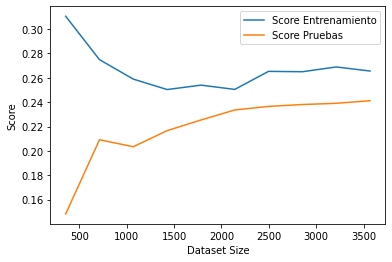

In [11]:
curva_entrenamiento(modelo, x, y)

## 2b. Clasificación  

### Sobreajuste en Clasificación. ¿Es igual?

![](images/05.png)

### Caso crítico

![](images/06.png)

### Otro tipo de Métricas

Nos permite enfocarnos en los casos importantes

- Verdadero positivo: El modelo dice que sí y la realidad es sí.
- Falso positivo: El modelo dice que sí y la realidad es No. - **Error tipo I**
- Falso negativo: El modelo dice que no y la realidad es sí. - **Error tipo II**
- Verdadero negativo: El modelo dice que no y la realidad es no.

El objetivo es minimizar los errores de tipo I y II.

![](images/07.png)

Porcentaje de predicciones correctas, independientemente de si son positivas o negativas. $R^2$

![](images/08.png)

El de sensibilidad se enfoca en los casos positivos

![](images/09.png)

Precision, sirve, por ejemplo, en el caso de la enfermedad, si se le dijo sí a todos.

![](images/0A.png)

Especificidad, sirve, por ejemplo, en el caso de la enfermedad, si se le dijo **No** a todos.

![](images/0B.png)

### Validación Gráfica

![](images/0C.png)

### Caso desbalanceado

- Modificar umbral
- Asignar pesos a las clases
- Generar datos para nivelar la cantidad de valores en las clases (OJO)

![](images/0D.png)

### Validación Gráfica

![](images/0E.png)

### ¿Y si son varias clases?

- One vs One: se hacen modelos de a parejas
- One vs Reast: lo que se ve en la imagen. Se harían 4 modelos, uno por clase, la franja verde se transladaría.

![](images/0F.png)

In [12]:
wine_df = pd.read_csv('data/winequality-red_clean.csv')
len(wine_df)

1571

In [13]:
y = wine_df['high_quality']
x = wine_df.drop(['high_quality'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

En nuestro notebook anterior, también hemos entrenado y guardado varios modelos de clasificación, que podemos validar en esta clase para encontrar el mejor:
- Regresión Logística (model_log.pkl)
- Vecinos más Cercanos (model_knn.pkl)
- Máquina de Soporte Vectorial (model_svm.pkl)
- Arbol de Desición (model_tree.pkl)
- Bosque Aleatorio (model_forest.pkl)

Elijamos inicialmente uno para hacer este laboratorio:

In [14]:
with open("models/model_svm.pkl","rb") as f:
    modelo = pickle.load(f)

### Matriz de Confusión
Ya vimos en la sesion toda la información útil que nos entrega una matriz de confusión y todas las métricas que podemos sacar de ella.  
Afortunadamente, Python ofrece una serie de librerías que nos permiten calcular los valores de la matriz y sus métricas automaticamente y sin necesidad de contarlas a mano, sin importar el tamaño del dataset.
> Vamos a agrupar éstas métricas y gráficas en una sola función y así poder llamarla recurrentemente para cualquier modelo

In [15]:
def plot_confussion_matrix(model, xtrain, ytrain, xtest, ytest, umbral=0.5):
    y_probs = model.predict_proba(xtest)
    y_pred = [int(p1 > umbral) for [p0, p1] in y_probs]
    conf = confusion_matrix(ytest, y_pred)
    conf = np.rot90(conf,2).T
    print(conf)

    print ('\n')
    print ("     Score:          %0.2f" %((conf[1,1]+conf[0,0])/(conf[1,1] + conf[0,1] + conf[0,0] + conf[1,0])))
    print ("     Precisión:      %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    print ("     Recall:         %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("     Especificidad:  %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[0, 1])))
    
    plt.figure()
    sns.heatmap(conf, annot=True, cmap='Reds')
    plt.tight_layout()
    plt.ylabel('Predicción Modelo')
    plt.xlabel('Realidad')

[[210 134]
 [ 39  89]]


     Score:          0.63
     Precisión:      0.61
     Recall:         0.84
     Especificidad:  0.40


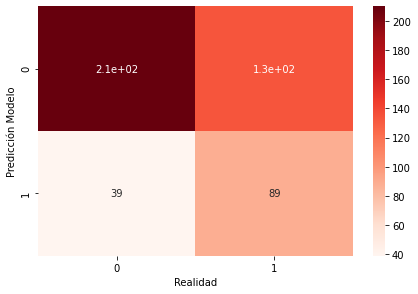

In [16]:
plot_confussion_matrix(modelo ,x_train, y_train, x_test, y_test)

### Curva ROC y AUC

La curva ROC (*Receiving Operating Characteristic*) y el área bajo ella, nos permiten validar gráficamente qué tan bien está prediciendo el modelo.  Se trata de una relacion entre la Tasa de Verdaderos Positivos (TPR o Sensitividad) que queremos aumentar y la de Falsos Positivos (FPR o 100 - Especificidad) que queremos disminuir.

Tenga en cuenta que el "Mejor modelo" es el que tiene **Área Bajo la Curva (AUC) = 1** es decir, pasa por la esquina superior izquierda (0,1) y el "Modelo Base" (Aleatorio) es el que tiene **Área Bajo la Curva (AUC) = 0.5** es decir pasa por la diagonal (1,1)

In [17]:
def plot_roc_curve(model, x_test, y_test):
    y_score=model.predict_proba(x_test)[:,1]
    #print(y_score)

    fpr, tpr, ths = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    # Plotting our Baseline..
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr,color='green')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Curva ROC (AUC = ' + str(roc_auc)+ ')')

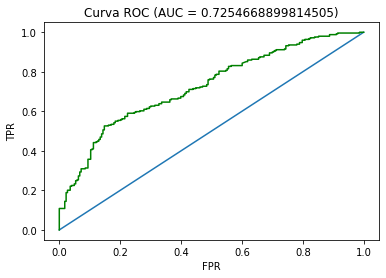

In [18]:
plot_roc_curve(modelo, x_test, y_test)

### Ajuste del Umbral

La curva ROC nos muestra los valores de TPR y FPR para diferentes umbrales del mismo modelo.  Debemos buscar un modelo que tenga el área bajo la curva máxima y entonces, elegir el umbral que aporte el valor máximo de esta curva.  pero cuál es ese umbral óptimo?

Si elegimos un umbral muy alto (Mayor a 0.5 y cercano a 1), el modelo clasificará una menor cantidad de casos positivos (TPR).  Si elegimos un umbral muy bajo (Menor a 0.5 y cercano a 0), el modelo clasificará una mayor cantidad de casos positivos y podría equivocarse (FPR).

In [19]:
def plot_precision_recall(model, x_test, y_test) :
    y_score = model.predict_proba(x_test)[:,1]
    p,r,t = precision_recall_curve(y_test,y_score)
    t=np.vstack([t.reshape([-1,1]),1])

    plt.plot(t,p, label='Precisión')
    plt.plot(t,r, label='Recall')
    plt.legend()
    plt.grid()

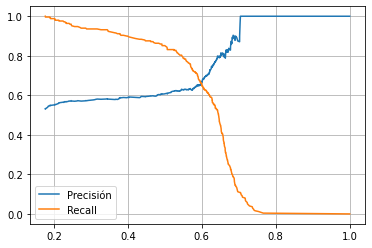

In [20]:
plot_precision_recall(modelo, x_test, y_test)

Es buena práctica, tomar como umbral para nuestro modelo, no siempre 0.5, sino el punto en el que las dos líneas se crucen tal que: La **precisión** del modelo aumente, pero no tanto para que el **recall** caiga demasiado.  

Recuerde que, al cambiar el umbral con el que se mide un modelo, se genera un modelo completamente diferente al que se le deben volver a medir las métricas de validación, por suerte, creamos una función para ello:

[[161  81]
 [ 88 142]]


     Score:          0.64
     Precisión:      0.67
     Recall:         0.65
     Especificidad:  0.64


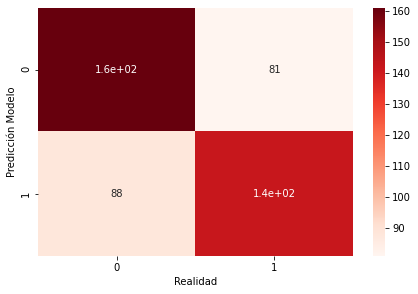

In [21]:
plot_confussion_matrix(modelo ,x_train, y_train, x_test, y_test, umbral=0.6)